In [152]:
import requests
import joblib
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pandas import option_context
from tqdm import tqdm
from statsmodels.stats.inter_rater import aggregate_raters
from sklearn.metrics import cohen_kappa_score
from scipy.stats import mannwhitneyu,shapiro,ttest_ind

import cliffsDelta as cd
import GenerateActivities as gat
import important_features as imf


In [ ]:
!pip install -r requirements.txt

In [ ]:
QUERY_ROOT = "https://api.github.com"
TOKEN = '' # write your GitHub API key here
HEADERS={'Authorization':'token '+TOKEN}

## Section 3

### Question 1

#### Write an automated Python script to identify all GitHub bot actors in the list of contributors, by querying the GitHub REST API users endpoint and extracting the required information to make this decision. 

#### More information: You can search for the "type" key in the obtianed JSON result, If it is "Bot", then it is a bot actor, if it is "User", then it is an account.

In [161]:
# 1. Read the given <sample>.csv file into a pandas DataFrame (df).
# 2. Make sure there are 2 columns, one column name is "contributor" that has the name of the contributor, 
#    and another column name is "bothunter_type" that you will use later on in this assignment.
# 3. Display the DataFrame.

# YOUR CODE BELOW

# Replace with the actual CSV file path
csv_file = "E:\software evolution\Software_Evolution_TP_bots\Contributors\sample7.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Ensure the required columns exist, otherwise create them
required_columns = ["contributor", "bothunter_type"]

# If "contributor" column is missing, raise an error
if "contributor" not in df.columns:
    raise ValueError("The CSV file must contain a 'contributor' column.")

# If "bothunter_type" is missing, add it with default empty values
if "bothunter_type" not in df.columns:
    df["bothunter_type"] = ""

# Display the DataFrame
print(df)

                      contributor bothunter_type
0                    Anurag-Varma          Human
1                 DilumAluthgeBot          Human
2                    ElektrikAkar          Human
3                JuliaRegistrator            Bot
4                   ManonMarchand          Human
5                  RussellGarwood          Human
6                   VincentAuriau          Human
7                     aloctavodia          Human
8                        avehtari          Human
9                  bioc-issue-bot            Bot
10                         bozaah          Human
11                     chainer-ci            Bot
12                        cpondoc          Human
13                     doronbehar          Human
14                      fingolfin          Human
15            github-actions[bot]            Bot
16  github-advanced-security[bot]            Bot
17                hackmd-hub[bot]            Bot
18                       harperjf          Human
19                  

In [162]:
# 1. Store the names of the contributors in a list
# 2. print the list

# YOUR CODE BELOW

# Store the contributor names in a list
contributors_list = df["contributor"].tolist()

# Print the list of contributors
print("List of contributors:", contributors_list)

List of contributors: ['Anurag-Varma', 'DilumAluthgeBot', 'ElektrikAkar', 'JuliaRegistrator', 'ManonMarchand', 'RussellGarwood', 'VincentAuriau', 'aloctavodia', 'avehtari', 'bioc-issue-bot', 'bozaah', 'chainer-ci', 'cpondoc', 'doronbehar', 'fingolfin', 'github-actions[bot]', 'github-advanced-security[bot]', 'hackmd-hub[bot]', 'harperjf', 'jClugstor', 'jmineau', 'kanav99', 'ldouteau', 'lumberbot-app[bot]', 'martenson', 'mergify[bot]', 'mikelkou', 'natalie-wa', 'oscarbenjamin', 'plover0226', 'rtimms', 'scverse-bot', 'slager', 'spyder-bot', 'sympy-bot', 'timholy', 'transifex-integration[bot]', 'weblate', 'welcome[bot]', 'wlandau']


In [163]:
# 1. Using a for loop, iterate over each contributor in the list and query the GitHub Users API.
#    You can use "query = f'{QUERY_ROOT}/users/{contributor}'", where QUERY_ROOT is defined at the beginning of this notebook 
#    and 'contributor' is each individual contributor from the list
# 2. Get the response using 'response = requests.get(query, headers=HEADERS)'.
# 3. convert the response to JSON using 'json_response = response.json()'.
# 4. Iterate over each JSON response and get the value of the 'type' key. If it is "Bot" then the contributor is a bot actor, 
#    if "User" then the contributor is an account. You should boolean values to indicate if the contributor is a bot actor (True) or User/Organisation (False)
# 5. Save these results in list of dictionary of the form [{'contributor': <contributor name>, 'app': <boolean value>}, {...}, {...}, {...}].
#    Lets call this list as "app_dict"
# 6. Finally convert this list of dictionary to DataFrame by writing 'pd.DataFrame.from_dict(app_dict)'
# 7. Display the DataFrame. This should have two columns - contributor and app

# YOUR CODE BELOW
app_dict = []

for contributor in contributors_list:
    query = f'{QUERY_ROOT}/users/{contributor}'
    response = requests.get(query,headers=HEADERS)

    if response.status_code == 200:
        json_response = response.json()
        is_bot = json_response.get("type") == "Bot"
        app_dict.append({"contributor": contributor, "app": is_bot})
    else:
        print(f"Error fetching data for {contributor}: {response.status_code}")

# Convert the list of dictionaries to a DataFrame
app_df = pd.DataFrame.from_dict(app_dict)

print(app_df)


                      contributor    app
0                    Anurag-Varma  False
1                 DilumAluthgeBot  False
2                    ElektrikAkar  False
3                JuliaRegistrator  False
4                   ManonMarchand  False
5                  RussellGarwood  False
6                   VincentAuriau  False
7                     aloctavodia  False
8                        avehtari  False
9                  bioc-issue-bot  False
10                         bozaah  False
11                     chainer-ci  False
12                        cpondoc  False
13                     doronbehar  False
14                      fingolfin  False
15            github-actions[bot]   True
16  github-advanced-security[bot]   True
17                hackmd-hub[bot]   True
18                       harperjf  False
19                      jClugstor  False
20                        jmineau  False
21                        kanav99  False
22                       ldouteau  False
23             l

### Question 2

#### Add a new 'actor' column in the CSV file to store this information. You can write True if it is a bot actor and False if it is not.

#### Report on the total number of GitHub bot actors, and User accounts present in the list of accounts of your dataset.

In [164]:
# Merge the app DataFrame to df by writing 'pd.merge(df, <app df>, on='contributor'). This is similar to SQL join on primary key 'contributor'.
# The resultant df should have 3 columns - contributor, bothunter_type and user_type.

# YOUR CODE BELOW
 
merged_df =pd.merge(df, app_df, on='contributor')


# Count the number of bot actors and user accounts
num_bots = merged_df["app"].sum()  # Count where actor is True
num_users = len(merged_df) - num_bots  # Remaining are users

# Save the updated DataFrame back to CSV
updated_csv_file = "updated_sample.csv"
merged_df.to_csv(updated_csv_file, index=False)

# Print the report
print(f"Total des Bot Actors sur GitHub : {num_bots}")
print(f"Total des Comptes Utilisateurs : {num_users}\n")

print(" Aperçu du fichier mis à jour :")
merged_df[merged_df["app"]==True] 

Total des Bot Actors sur GitHub : 7
Total des Comptes Utilisateurs : 33

 Aperçu du fichier mis à jour :


,contributor,bothunter_type,app
15,github-actions[bot],Bot,True
16,github-advanced-security[bot],Bot,True
17,hackmd-hub[bot],Bot,True
23,lumberbot-app[bot],Bot,True
25,mergify[bot],Bot,True
36,transifex-integration[bot],Bot,True
38,welcome[bot],Bot,True


### Question 3

#### For each bot actor, write their purpose, the task that they automate by looking at their GitHub profile, homepage, information on the GitHub Marketplace, or other documentation that you can find online.


 github-actions[bot]: 

 is a CI/CD (Continuous Integration/Continuous Deployment) platform that allows developers to automate their build, test, and deployment pipelines. It enables the creation of workflows that can be triggered by various events in a repository, such as pull requests, issues, or commits

github-advanced-security[bot]:

offers enhanced security features to help improve and maintain the quality of your code. These features are available for enterprise accounts on GitHub Enterprise Cloud and GitHub Enterprise Server, and some are also available for public repositories on GitHub
 
 hackmd-hub[bot]:

 is a real-time collaborative Markdown editor that syncs with GitHub.
Join Kuberenetes, Ruby-lang, Matplotlib, Microsoft and many others in collaborating on markdown docs!
With this app, you can:
 Collaborate on Markdown files
 Sync HackMD Markdown files with GitHub repository
 Let the community know where live collaboration is happening

 mergify[bot]:

Mergify is a solution making your code merge faster, safer, and cheaper by virtue of:
The Merge Queue - Queue, Update and Merge your Pull Requests.
The Workflow Automation - Automate your code merge processes.

transifex-integration[bot]: 
Seamlessly connect and integrate your GitHub repositories to your Transifex projects. Once integrated: Fully translated content from your Transifex project will be automatically pushed back to your GitHub repository (via commit or Pull Request, depending on which you select).


## Section 4

### Question 1

#### Write an automated script to use BIMBAS (Bot Identification Model Based on Activity Sequences) to obtain a prediction of the GitHub contributor type (Bot or Human) for the contributors present in your dataset.

#### Folow the steps given in each cell to use BIMBAS and obtain predictions.

### Read all the events and select the events performed by the contributors present in the given set

In [165]:
# 1. Read the csv file of events (all_events.csv) provided along with this notebook
# 2. Convert created_at column to datetime format 
#    One possible way is to use lambda function: "events.assign(created_at=lambda d: pd.to_datetime(d.created_at, unit='ms'))"
# 3. Get the contributors provided to you in a list or use the contributors list that you created in Section 3 Question 1. 
#    e.g., ['contributor1', 'contributor2', 'contributor3',...]
# 4. Select the events performed by these contributors alone. Do not consider all the events. You should consider only the events
#    performed by the contributors provided to you. Hint: you can use the df.query function
# 5. Display the considered events.

# YOUR CODE BELOW

#  Load the events CSV file
events_file = "all_events.csv"  
events = pd.read_csv(events_file)

#  Convert 'created_at' column to datetime format
events = events.assign(created_at=lambda d: pd.to_datetime(d.created_at, unit='ms'))
  

#  Filter events to include only those performed by contributors in the list
filtered_events = events.query("login in @contributors_list")

#  Display the considered events
filtered_events



,Unnamed: 0,event_id,event_type,login,repository,created_at,action,PR_number,state,PR_node_id,...,comment_node_id,merged,ref,ref_type,issue_number,issue_node_id,issue_closed_at,tag_name,release_node_id,org
6,6,39747396929,CommitCommentEvent,github-actions[bot],QuantEcon/lecture-python-intro,2024-07-01 00:01:47,NaN,NaN,NaN,NaN,...,CC_kwDOIy5DFs4IkKwX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QuantEcon
15,15,39747413489,CommitCommentEvent,github-actions[bot],QuantEcon/lecture-python-intro,2024-07-01 00:03:24,NaN,NaN,NaN,NaN,...,CC_kwDOIy5DFs4IkKw0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QuantEcon
16,16,39747416135,PushEvent,github-actions[bot],napari/npe2api,2024-07-01 00:03:40,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,napari
21,21,39747427332,CreateEvent,github-actions[bot],SciML/PubChem.jl,2024-07-01 00:04:44,NaN,NaN,NaN,NaN,...,NaN,NaN,compathelper/new_version/2024-07-01-00-04-42-9...,branch,NaN,NaN,NaN,NaN,NaN,SciML
30,30,39747452343,IssueCommentEvent,github-actions[bot],pandas-dev/pandas,2024-07-01 00:07:06,created,58814.0,open,PR_kwDOAA0YD85wSOEO,...,IC_kwDOAA0YD86DD0Tu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pandas-dev
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358385,358385,42415261485,CommitCommentEvent,JuliaRegistrator,SciML/LineSearch.jl,2024-09-30 23:21:33,NaN,NaN,NaN,NaN,...,CC_kwDOLCAB0M4IyT9_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SciML
358391,358391,42415303969,PushEvent,github-actions[bot],SciML/LineSearch.jl,2024-09-30 23:24:21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SciML
358401,358401,42415474205,PushEvent,github-actions[bot],Bioconductor/gha-build-jupyter-release-amd64,2024-09-30 23:34:53,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bioconductor
358403,358403,42415512378,PushEvent,github-actions[bot],napari/npe2api,2024-09-30 23:37:12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,napari


### Execute BIMBAS to obtain the predictions

In [167]:
# Do not modify this cell
# Use the following function the code below to obtain your predictions

def execute_bimbas(contributors_list, selected_events):
    '''
    args: contributors_list (list) - list of contributors in the dataset provided to you
          selected_events (DataFrame) - DataFrame of events performed by the considered contributors
    return: bimbas_prediction (DataFrame) - DataFrame of preditions along with the confidence in prediction for each contributor
    '''
    result=pd.DataFrame()
    temp_list = []
    bimbas = joblib.load('bimbas.joblib')
    date_limit = pd.to_datetime(selected_events.created_at.max()) + pd.DateOffset(-90)
    
    for contributor in tqdm(contributors_list):
        # c = contributors[contributor]
        activities = gat.activity_identification(selected_events.query('login==@contributor and created_at>=@date_limit'))
        activity_features = (
                            imf.extract_features(activities)
                            .set_index([[contributor]])
                            )
        # features = pd.concat([features,activity_features])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            probability = bimbas.predict_proba(activity_features)[0][1]
        if(probability <= 0.5):
            contributor_type = 'Human'
        else:
            contributor_type = 'Bot'
        confidence = (abs(probability - 0.5)*2).round(3)
    
        pred = activity_features.set_index([[contributor]]).assign(
            prediction=contributor_type,
            confidence = confidence,
            )
        temp_list.extend([{'contributor':contributor,'bimbas_type':contributor_type,'confidence':confidence}])
    
    bimbas_prediction = pd.DataFrame.from_dict(temp_list)

    return(bimbas_prediction)

In [168]:
# Write your code here to call execute_bimbas function. 
# Pass the contributors list and the filtered events DataFrame as argument to "execute_bimbas" function
# Prediction returned by BIMBAS will have "contributor", "bimbas_type" and "confidence"
# Note: Print the prediction provided by BIMBAS - else this cell will not be graded.

# YOUR CODE BELOW

bimbas_predict = execute_bimbas(contributors_list, filtered_events)

bimbas_predict

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:14<00:00,  2.76it/s]


,contributor,bimbas_type,confidence
0,Anurag-Varma,Human,0.862
1,DilumAluthgeBot,Bot,0.894
2,ElektrikAkar,Human,0.781
3,JuliaRegistrator,Bot,0.886
4,ManonMarchand,Human,0.903
5,RussellGarwood,Bot,0.890
6,VincentAuriau,Bot,0.731
7,aloctavodia,Human,0.630
8,avehtari,Human,0.776
9,bioc-issue-bot,Bot,0.548


### Create a column in your predictions DataFrame to have predictions provided by BIMBAS. 
### Now your DataFrame should have the following columns - contributor, bothunter_type, app, bimbas_type, confidence 

### Merging bothunter and bimbas predictions

In [169]:
# Merge the predictions provided by BIMBAS to the resultant dataset of Section 3. This final DataFrame should have the following columns - 
# contributor, bothunter_type, user_type, bimbas_type, and confidence.

merged_df_bim =pd.merge(merged_df, bimbas_predict, on='contributor')

# Save the updated DataFrame back to CSV
updated_csv_file2 = "updated_sample2.csv"
merged_df_bim.to_csv(updated_csv_file2, index=False)

print(" Aperçu du fichier mis à jour :")
merged_df_bim[merged_df_bim["app"]==True] 

 Aperçu du fichier mis à jour :


,contributor,bothunter_type,app,bimbas_type,confidence
15,github-actions[bot],Bot,True,Bot,0.145
16,github-advanced-security[bot],Bot,True,Bot,0.703
17,hackmd-hub[bot],Bot,True,Bot,0.751
23,lumberbot-app[bot],Bot,True,Bot,0.912
25,mergify[bot],Bot,True,Human,0.786
36,transifex-integration[bot],Bot,True,Bot,0.535
38,welcome[bot],Bot,True,Bot,0.727


### Question 2
#### Using Cohen's Kappa compute and report the interrater agreement score between the labels computed by both the bot identification approaches. Mention your interpretation of Cohen's Kappa

In [170]:
# Hint: use the cohen_kappa_score library
# YOUR CODE BELOW
ck = cohen_kappa_score(merged_df_bim.bothunter_type, merged_df_bim.bimbas_type)

print(f'Cohen Kappa Score= ',ck)

Cohen Kappa Score=  0.6


 ## Interpretation 
 
 Cohen's Kappa score is 0.6, indicating a moderate to substantial level of agreement between the two bot detection methods.

 A score of 0.6 means that around 60% of classifications are aligned, while 40% show discrepancies.
 So there's good agreement between the GitHub API's classification of bots and BIMBAS, but there are some differences.
In fact, GitHub classifies a user as a "Bot" according to its official status, whereas BIMBAS uses a model based on the behavior of the user.


### Question 3
#### Determine the final type of each contributor. Whenever user_type column has the value "User" check if both bimbas_type and bothunter_type give the same prediction, then consider it as your final prediction in "acc_type" column.
#### For the contributors that have different predictions, i.e. bimbas_type is not same as bothunter_type, then make a manual verification and consider that as the type for that contributor. Add an extra column to the DataFrame ﬁle called 'manual' that has the label determined by you. 
#### For manual verification you can make use the GitHub UI and the GitHub API https://api.github.com/users/username

#### Whenever user_type column has the value "Bot", directly write your final acc_type as "Bot Actor"

#### More information:
For each contributor, you can look at their activities in GitHub UI, look at their latest events using GitHub Events API - https://api.github.com/users/<contributor>/events, to make a decision on their type.

In addition, you can also write a very small reason why do you think they are bot or human (e.g., same activity at regular interval so Bot, files committed and code modified looks like Human, comments look like Human, comment look like Bot, test report looks automated so Bot, and so on....). This will be useful to answer your next question.

In [171]:
# Write the code for your manual decision here
# example : 
# manual_list_dict = [{'contributor': '<contributor name>', 'manual': '<your prediction>'}, {....}, {....}, {....}]
# pd.DataFrame.from_dict(manual_list_dict)

# YOUR CODE BELOW

manual_list_dict = [
    {'contributor': 'Anurag-Varma', 'manual': 'Human'}, 
    {'contributor': 'mergify[bot]', 'manual': 'Bot'}, 
    {'contributor': 'DilumAluthgeBot', 'manual': 'Bot'}, 
    {'contributor': 'ldouteau', 'manual': 'Human'}, 
    {'contributor': 'scverse-bot', 'manual': 'Bot'}, 
    {'contributor': 'weblate', 'manual': 'Human'} 
    ]

# Convert manual verifications to DataFrame
manual_df = pd.DataFrame.from_dict(manual_list_dict)

# Display the manual verification DataFrame
manual_df


,contributor,manual
0,Anurag-Varma,Human
1,mergify[bot],Bot
2,DilumAluthgeBot,Bot
3,ldouteau,Human
4,scverse-bot,Bot
5,weblate,Human


In [172]:
# Write your code below here to determine the final type of contributor.
# add column named 'acc_type' and write your final decision in it. Final decision is majority of three types - bimbas_type, bothunter_type, manual.
merged_df = pd.merge(merged_df_bim, manual_df, on='contributor')
 
def determine_final_type(row):
    types = [row['bothunter_type'], row['bimbas_type'], row['manual']]
    return max(set(types), key=types.count)
 
merged_df['acc_type'] = merged_df.apply(determine_final_type, axis=1)
 
merged_df

,contributor,bothunter_type,app,bimbas_type,confidence,manual,acc_type
0,Anurag-Varma,Human,False,Human,0.862,Human,Human
1,DilumAluthgeBot,Human,False,Bot,0.894,Bot,Bot
2,ldouteau,Human,False,Human,0.776,Human,Human
3,mergify[bot],Bot,True,Human,0.786,Bot,Bot
4,scverse-bot,Bot,False,Bot,0.262,Bot,Bot
5,weblate,Bot,False,Bot,0.866,Human,Bot


### Question 4
#### Study and report the purpose of these identified bots and humans in the repository assigned to you.
#### For example, the purpose can be based on but not limited to - 
##### 1) the type of activities that they are performing (releasing a version on every Sunday, updating the documentation), 
##### 2) type of comments they are posting (reviewing code, test summary report), 
##### 3) when are they triggered (when a new PR is created, when someone in the project ask the bot to merge the code) and so on.  
#### Note: 
##### The purpose can be other than what is provided in examples above.


### **1. JuliaRegistrator (Bot)**
- **Purpose**: Automates package registration in Julia.
- **Activities**: Tracks and registers new Julia packages or updates when developers request them.
- **Trigger**: When a new package update is submitted by a contributor.

### **2. bioc-issue-bot (Bot)**
- **Purpose**: Manages issues related to Bioconductor.
- **Activities**: Monitors and assigns issues, provides automated responses, and ensures issues are categorized properly.
- **Trigger**: When a new issue is created or when an issue needs assignment.

### **3. chainer-ci (Bot)**
- **Purpose**: Continuous Integration (CI) for Chainer library.
- **Activities**: Runs automated tests on pull requests, ensures code correctness before merging.
- **Trigger**: Whenever a new PR is created or updated.

### **4. github-actions[bot]**
- **Purpose**: Runs CI/CD workflows.
- **Activities**: Executes tests, deploys applications, and automates repository maintenance.
- **Trigger**: Based on predefined workflows (e.g., on push, PR creation, scheduled tasks).

### **5. github-advanced-security[bot]**
- **Purpose**: Scans for security vulnerabilities in code and dependencies.
- **Activities**: Runs security audits, alerts developers on vulnerabilities, and suggests fixes.
- **Trigger**: Periodically or when new code is pushed.

### **6. hackmd-hub[bot]**
- **Purpose**: Syncs documentation with HackMD collaborative documents.
- **Activities**: Updates repository files with the latest HackMD changes.
- **Trigger**: When documentation is modified in HackMD.

### **7. lumberbot-app[bot]**
- **Purpose**: Assists with repository automation.
- **Activities**: Performs bulk issue handling, labeling, and merging.
- **Trigger**: Based on repository events like issue creation or pull request updates.

### **8. transifex-integration[bot]**
- **Purpose**: Manages translations for internationalization.
- **Activities**: Syncs translated strings between Transifex and the repository.
- **Trigger**: When new text content is added that requires translation.

### **9. weblate (Bot)**
- **Purpose**: Automates translation workflow.
- **Activities**: Integrates with Weblate to update translated files in the repository.
- **Trigger**: When new translations are added or reviewed.

### **10. welcome[bot]**
- **Purpose**: Greets new contributors.
- **Activities**: Posts automated welcome messages on first-time contributions.
- **Trigger**: When a new contributor opens an issue or PR.

---


### **1. Anurag-Varma, ManonMarchand, VincentAuriau, aloctavodia, avehtari, bozaah, cpondoc, doronbehar, fingolfin, harperjf, jClugstor, jmineau, kanav99, ldouteau, RussellGarwood, wlandau**
- **Purpose**: General contributors who contribute code, review pull requests, report issues, and improve documentation.
- **Activities**: Developing new features, fixing bugs, improving documentation, and reviewing others' contributions.

### **2. DilumAluthgeBot (Human)**
- **Purpose**: Manages Julia package updates and automation scripts.
- **Activities**: Creates automation scripts to update dependencies and maintain package integrity.

### **3. ElektrikAkar (Human)**
- **Purpose**: Involved in reviewing and maintaining the codebase.
- **Activities**: Code review, testing new features, and handling bug reports.

### **4. JuliaRegistrator (Human Supervisor)**
- **Purpose**: Oversees JuliaRegistrator bot operations.
- **Activities**: Ensures the bot is functioning correctly and manually intervenes when needed.

### **5. RussellGarwood (Human)**
- **Purpose**: Contributes to repository documentation and user experience improvements.
- **Activities**: Enhances documentation and provides feedback on usability.





## Section 5

### Question 1
#### Use the filtered events file that has the events performed by the contributors provided to you
#### Group each event into the following four categories

Issues: IssueCommentEvent, IssuesEvent  
Pull Requests: PullRequestEvent, PullRequestReviewCommentEvent  
Commits: CommitCommentEvent, PushEvent  
Repository: CreateEvent, DeleteEvent, ForkEvent, GollumEvent, MemberEvent, PublicEvent, ReleaseEvent, SponsorshipEvent, WatchEvent  

#### Hint:
1. Add a column called event_group that mentions which event group does that event belong to. Each event (row) should correspond to an event group.  
2. Then perform groupby on ['login','event_group'],  
3. use .agg (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html) to count the number of events performed by each contributor in each group,  
4. use pivot with the required arguments (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html). An example is given [here](#pivot_example) in question 2(b), and
5. Reset index and rename axis with None
7. Finally merge it with your 'acc_type' field from the DataFrame you created in Section4, drop contributor, and fillna with 0
8. The final DataFrame should have the following columns - login, PR, commit, issue, repo, acc_type

The final DataFrame should be looking like the following  
![](event_group.png)

In [173]:
# In the resultant DataFrame - each row should corespond to a contributor, and the columns should have all the event groups  
# and the type of the contributor (that you decided in the previous DataFrame) and the values should be the number 
# of events of that event event group the contriubutor has performed.

issue_group = ['IssueCommentEvent', 'IssuesEvent']
pr_group = ['PullRequestEvent', 'PullRequestReviewCommentEvent']
commit_group = ['CommitCommentEvent', 'PushEvent']
repo_group = ['CreateEvent', 'DeleteEvent', 'ForkEvent', 'GollumEvent', 'MemberEvent', 'PublicEvent', 'ReleaseEvent', 'SponsorshipEvent', 'WatchEvent']

In [174]:
# YOUR CODE BELOW


def categorize_event(event_type):
    if event_type in ['IssueCommentEvent', 'IssuesEvent']:
        return 'issue'
    elif event_type in ['PullRequestEvent', 'PullRequestReviewCommentEvent']:
        return 'PR'
    elif event_type in ['CommitCommentEvent', 'PushEvent']:
        return 'commit'
    elif event_type in ['CreateEvent', 'DeleteEvent', 'ForkEvent', 'GollumEvent', 'MemberEvent', 'PublicEvent', 'ReleaseEvent', 'SponsorshipEvent', 'WatchEvent']:
        return 'repo'
    else:
        return 'other'

filtered_events.loc[:, 'event_group'] = filtered_events['event_type'].apply(categorize_event)
 
# 2. Grouper les événements par login et event_group
grouped_events = filtered_events.groupby(['login', 'event_group']).agg(event_count=('event_id', 'count')).reset_index()
 
# 3. Utiliser pivot pour réorganiser les données
pivot_df = grouped_events.pivot(index='login', columns='event_group', values='event_count').fillna(0).reset_index()
 
# 4. Réinitialiser l'index et renommer l'axe
pivot_df.columns.name = None
 
# 5. Fusionner avec le DataFrame contenant acc_type
final_df_with_acc_type = merged_df[['contributor', 'acc_type']].rename(columns={'contributor': 'login'})
final_df = pd.merge(pivot_df, final_df_with_acc_type, on='login')
 
# 6. Remplir les valeurs manquantes avec 0
final_df = final_df.fillna(0)

# 7. Afficher le DataFrame final
final_df


 

C:\Users\ingri\AppData\Local\Temp\ipykernel_31924\2408052528.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_events.loc[:, 'event_group'] = filtered_events['event_type'].apply(categorize_event)


,login,PR,commit,issue,other,repo,acc_type
0,Anurag-Varma,13.0,0.0,31.0,11.0,2.0,Human
1,DilumAluthgeBot,24.0,0.0,0.0,0.0,0.0,Bot
2,ldouteau,3.0,0.0,6.0,3.0,1.0,Human
3,mergify[bot],1.0,1.0,17.0,0.0,1.0,Bot
4,scverse-bot,36.0,72.0,0.0,0.0,15.0,Bot
5,weblate,16.0,0.0,0.0,0.0,0.0,Bot


### Question 2 (a)

#### Compute the median number of events per event group for Bot+Bot actors and Humans and write in DataFrame.

Row should correspond to type (Bot_BotActor and Human), Column should have Event group name and the values should be the median value of Bot_BotActor or Human for that particular event group. An example is given below

In [175]:
# YOUR CODE BELOW

# 1. Utiliser melt pour transformer le DataFrame
melted_df = final_df.melt(id_vars=['login', 'acc_type'], value_vars=['PR', 'commit', 'issue', 'repo'], var_name='event_group', value_name='event_count')
 
# 2. Grouper les données par acc_type et event_group et calculer la médiane
medians = melted_df.groupby(['acc_type', 'event_group'])['event_count'].median().reset_index()
 
# 3. Renommer la colonne 'event_count' en 'median'
medians.rename(columns={'event_count': 'median'}, inplace=True)
 
# 4. Réorganiser les colonnes dans l'ordre souhaité
medians = medians[['event_group', 'median', 'acc_type']]
 
# Afficher le DataFrame des médianes
medians

,event_group,median,acc_type
0,PR,20.0,Bot
1,commit,0.5,Bot
2,issue,0.0,Bot
3,repo,0.5,Bot
4,PR,8.0,Human
5,commit,0.0,Human
6,issue,18.5,Human
7,repo,1.5,Human


### Question 2 (b)

Plot a heatmap of the DataFrame using seaborn - 
1. First convert the dataframe to the required format using pivot, example is given below
2. plot using seaborn - sns.heatmap(df_medians, annot=True, vmin=0, vmax=300, cmap="crest"). More details: https://seaborn.pydata.org/generated/seaborn.heatmap.html)

#### pd.pivot example:
<a id='pivot_example'></a>

In [176]:
# pivot the main DataFrame
median_df =medians.pivot(index='acc_type', columns='event_group', values='median')#.reset_index().rename_axis(None,axis=1)
median_df

event_group,PR,commit,issue,repo
acc_type,,,,
Bot,20.0,0.5,0.0,0.5
Human,8.0,0.0,18.5,1.5


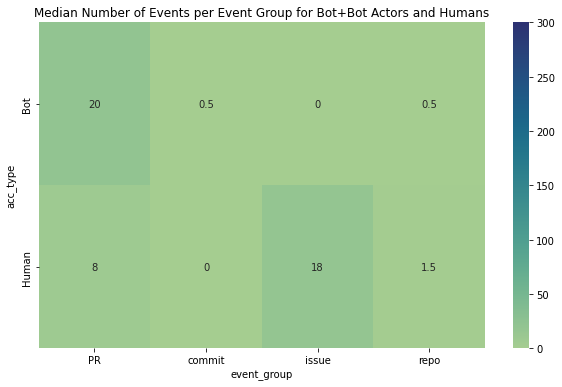

In [177]:
# YOUR CODE BELOW

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(median_df, annot=True, vmin=0, vmax=300, cmap="crest")
plt.title('Median Number of Events per Event Group for Bot+Bot Actors and Humans')
plt.show()

#### What is the difference that you observe between Bots+Bot actors and Humans?


   - Bots+Bot actors have higher median values in the `commit` and `PR` event groups, indicating that they are more active in automated tasks such as commits and pull requests.
   - Humans have higher median values in the `issue` event group, suggesting that they are more involved in issue tracking and discussions.
   - The median number of `commit` events is significantly higher for Bots+Bot actors compared to Humans, which is expected as bots often handle repetitive commit tasks.
   - Humans show higher median values in the `repo` event group, indicating their involvement in repository management activities.

.

#### What is the differnce that you observe between Event groups?


   - The `commit` event group has higher median values for Bots+Bot actors, indicating a high level of automated commit activity.
   - The `issue` event group has higher median values for Humans, suggesting that issue tracking and discussions are more human-centric activities.
   - The `PR` (Pull Request) event group shows significant activity for both Bots+Bot actors and Humans, reflecting its importance in the code review and integration process.
   - The `repo` event group has a more balanced distribution of median values, indicating that both Bots+Bot actors and Humans are involved in repository management tasks.



#### What is the difference that you observe between Bots+Bot actors and Humans and Event groups all considering at the same time?

   - Bots+Bot actors generally have higher median values in the `commit` and `PR` event groups, indicating a higher level of automated activity in these areas.
   - Humans have higher median values in the `issue` event group, suggesting that issue tracking and discussions are more human-centric activities.
   - The `commit` shows significantly higher median values for Bots+Bot actors compared to Humans, reflecting the automation of commit tasks.
   - The `issue` has higher median values for Humans, indicating their active involvement in issue tracking and resolution.
   - The `PR` shows substantial activity for both Bots+Bot actors and Humans, highlighting its importance in the code review and integration process.
   - The `repo` has a more balanced distribution of median values, with both Bots+Bot actors and Humans contributing to repository management tasks.

### Question 3

#### Create boxen plots to visualise the distribution of number of events in each event group. 
#### For more information you can visit - https://seaborn.pydata.org/generated/seaborn.boxenplot.html#seaborn.boxenplot 
#### You should highlight the data points that correspond to bots using a stripplot in seaborn. https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial  
#### Interpret the results of the visualisation.

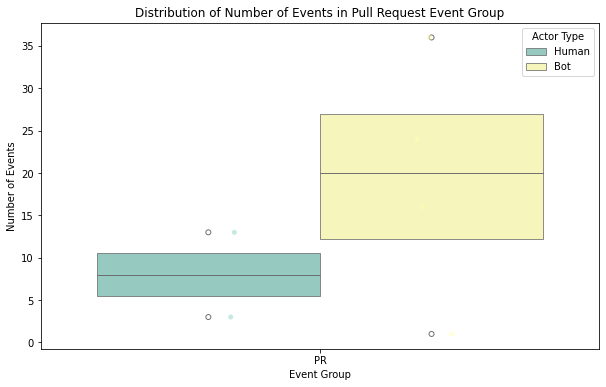

In [ ]:
# YOUR CODE BELOW - Visualize number of events from pull request event group

# Prepare the data
filtered_events.loc[:, 'event_group'] = filtered_events['event_type'].apply(categorize_event)

# Group events by login and event_group
grouped_events = filtered_events.groupby(['login', 'event_group']).agg(event_count=('event_id', 'count')).reset_index()

# Merge with the DataFrame containing acc_type
final_df_with_acc_type = merged_df[['contributor', 'acc_type']].rename(columns={'contributor': 'login'})
final_df = pd.merge(grouped_events, final_df_with_acc_type, on='login')

# Filter data for the 'PR' event group
pr_events = final_df[final_df['event_group'] == 'PR']

# Create boxen plot for the 'PR' event group
plt.figure(figsize=(10, 6))
sns.boxenplot(x='event_group', y='event_count', hue='acc_type', data=pr_events, palette='Set3')

# Overlay stripplot to highlight bot data points
sns.stripplot(x='event_group', y='event_count', hue='acc_type', data=pr_events, dodge=True, marker='o', alpha=0.5, palette='Set3')

# Adjust the legend to avoid duplication
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], title='Actor Type')

plt.title('Distribution of Number of Events in Pull Request Event Group')
plt.xlabel('Event Group')
plt.ylabel('Number of Events')
plt.show()

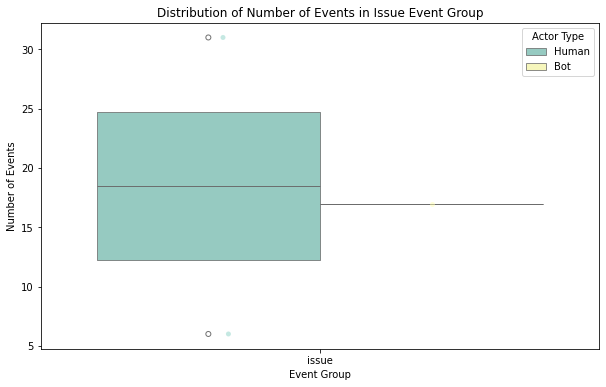

In [ ]:
# YOUR CODE BELOW - Visualise number of events from issue event group

# Filter data for the 'issue' event group
pr_events = final_df[final_df['event_group'] == 'issue']

# Create boxen plot for the 'issue' event group
plt.figure(figsize=(10, 6))
sns.boxenplot(x='event_group', y='event_count', hue='acc_type', data=pr_events, palette='Set3')

# Overlay stripplot to highlight bot data points
sns.stripplot(x='event_group', y='event_count', hue='acc_type', data=pr_events, dodge=True, marker='o', alpha=0.5, palette='Set3')

# Adjust the legend to avoid duplication
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], title='Actor Type')

plt.title('Distribution of Number of Events in Issue Event Group')
plt.xlabel('Event Group')
plt.ylabel('Number of Events')
plt.show()

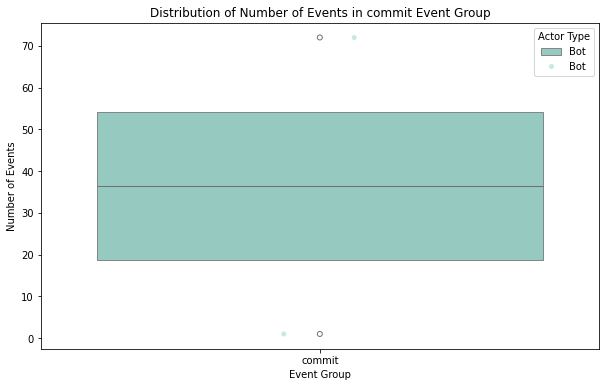

In [ ]:
# YOUR CODE BELOW - Visualise number of events from commit event group

# Filter data for the 'commit' event group
pr_events = final_df[final_df['event_group'] == 'commit']

# Create boxen plot for the 'commit' event group
plt.figure(figsize=(10, 6))
sns.boxenplot(x='event_group', y='event_count', hue='acc_type', data=pr_events, palette='Set3')

# Overlay stripplot to highlight bot data points
sns.stripplot(x='event_group', y='event_count', hue='acc_type', data=pr_events, dodge=True, marker='o', alpha=0.5, palette='Set3')

# Adjust the legend to avoid duplication
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], title='Actor Type')

plt.title('Distribution of Number of Events in commit Event Group')
plt.xlabel('Event Group')
plt.ylabel('Number of Events')
plt.show()

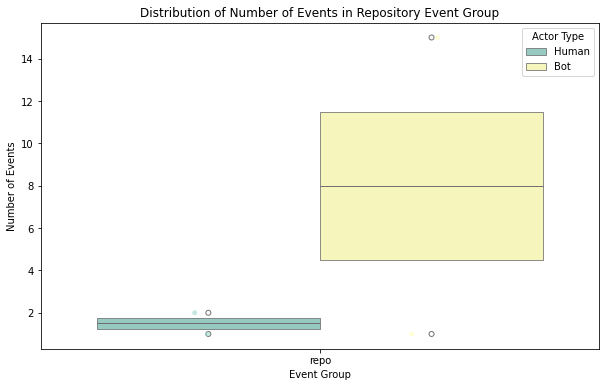

In [ ]:
# YOUR CODE BELOW - Visualise number of events from repo event group

# Filter data for the 'repo' event group
repo_events = final_df[final_df['event_group'] == 'repo']

# Create boxen plot for the 'repo' event group
plt.figure(figsize=(10, 6))
sns.boxenplot(x='event_group', y='event_count', hue='acc_type', data=repo_events, palette='Set3')

# Overlay stripplot to highlight bot data points
sns.stripplot(x='event_group', y='event_count', hue='acc_type', data=repo_events, dodge=True, marker='o', alpha=0.5, palette='Set3')

# Adjust the legend to avoid duplication
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], title='Actor Type')

plt.title('Distribution of Number of Events in Repository Event Group')
plt.xlabel('Event Group')
plt.ylabel('Number of Events')
plt.show()

### Question 4.1

#### Statistical identify whether number of events in each event group is normally distributed or not.
#### Null hypothesis - $H_0$: Sample comes from the data that has normal distribution.
#### Use Shapiro-Wilk test for this purpose. Use the p-value with a threshold of 0.05 to determine whether $H_0$ can be rejected with statistical significance or not. 

#### Use shapiro from scipy.stats to perform this test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

In [ ]:
# YOUR CODE BELOW

from scipy.stats import shapiro

# Perform Shapiro-Wilk test for each event group
event_groups = final_df['event_group'].unique()
shapiro_results = {}

for group in event_groups:
    group_data = final_df[final_df['event_group'] == group]['event_count']
    stat, p_value = shapiro(group_data)
    shapiro_results[group] = p_value

# Display the results
for group, p_value in shapiro_results.items():
    if p_value > 0.05:
        print(f"The number of events in the '{group}' event group is normally distributed (p-value = {p_value:.4f}).")
    else:
        print(f"The number of events in the '{group}' event group is not normally distributed (p-value = {p_value:.4f}).")

The number of events in the 'PR' event group is normally distributed (p-value = 0.7345).
The number of events in the 'issue' event group is normally distributed (p-value = 0.8679).
The number of events in the 'other' event group is not normally distributed (p-value = nan).
The number of events in the 'repo' event group is not normally distributed (p-value = 0.0068).
The number of events in the 'commit' event group is not normally distributed (p-value = nan).


C:\Users\ingri\AppData\Local\Temp\ipykernel_31924\1569690152.py:11: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p_value = shapiro(group_data)


### Question 4.2
#### Determine if there is any statistical diﬀerence in number of events between the identified event groups. Perform this test on all pairs of event groups. 
#### Null hypothesis - $H_0$: Any two event group come from the same population.
#### If $H_0$ is rejected in Shapiro-Wilk test (at least for one of the two event groups considered for test), use the Mann-Whitney U statistical test for this purpose. If $H_0$ is not rejected in Shapiro-Wilk test, use the independent t-test for this purpose.  
#### In any case, use the p-value with a threshold of 0.01 to determine whether $H_0$ can be rejected with statistical significance. 

#### Use mannwhitneyu from scipy.stats to perform Mann-Whitney U test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) 
#### or 
#### ttest_ind from scipy.stats to perform independent t-test https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html.

#### More information:

You can pass the following arguments to mannwhitneyu from scipy.stats - (method='exact', nan_policy='omit'). For ttest_ind you can use - (nan_policy='omit')

In [ ]:
# YOUR CODE BELOW
from scipy.stats import mannwhitneyu, ttest_ind
import itertools

# Function to determine if data is normally distributed
def is_normal(p_value):
    return p_value > 0.05

# Perform pairwise comparisons
pairwise_results = []

for group1, group2 in itertools.combinations(event_groups, 2):
    data1 = final_df[final_df['event_group'] == group1]['event_count']
    data2 = final_df[final_df['event_group'] == group2]['event_count']
    
    p_value1 = shapiro_results[group1]
    p_value2 = shapiro_results[group2]
    
    if not is_normal(p_value1) or not is_normal(p_value2):
        # Use Mann-Whitney U test
        stat, p_value = mannwhitneyu(data1, data2)
        test_type = 'Mann-Whitney U'
    else:
        # Use independent t-test
        stat, p_value = ttest_ind(data1, data2)
        test_type = 'Independent t-test'
    
    pairwise_results.append({
        'group1': group1,
        'group2': group2,
        'test_type': test_type,
        'p_value': p_value
    })

# Display the results
for result in pairwise_results:
    if result['p_value'] < 0.01:
        print(f"There is a statistical difference between '{result['group1']}' and '{result['group2']}' (p-value = {result['p_value']:.4f}, {result['test_type']}).")
    else:
        print(f"There is no statistical difference between '{result['group1']}' and '{result['group2']}' (p-value = {result['p_value']:.4f}, {result['test_type']}).")

There is no statistical difference between 'PR' and 'issue' (p-value = 0.7932, Independent t-test).
There is no statistical difference between 'PR' and 'other' (p-value = 0.5024, Mann-Whitney U).
There is no statistical difference between 'PR' and 'repo' (p-value = 0.1606, Mann-Whitney U).
There is no statistical difference between 'PR' and 'commit' (p-value = 1.0000, Mann-Whitney U).
There is no statistical difference between 'issue' and 'other' (p-value = 0.4000, Mann-Whitney U).
There is no statistical difference between 'issue' and 'repo' (p-value = 0.1084, Mann-Whitney U).
There is no statistical difference between 'issue' and 'commit' (p-value = 1.0000, Mann-Whitney U).
There is no statistical difference between 'other' and 'repo' (p-value = 0.4811, Mann-Whitney U).
There is no statistical difference between 'other' and 'commit' (p-value = 1.0000, Mann-Whitney U).
There is no statistical difference between 'repo' and 'commit' (p-value = 0.8057, Mann-Whitney U).


### Question 4.3
#### Each time you reject the null hypothesis $H_0$, quantify the effect size of the diﬀerence between the groups using cliﬀ’s delta ($\delta$). 
#### To calculate cliﬀ’s delta, you can pass the list of values to cliﬀ delta.py file given in the repository. E.g., cliffsDelta.cliffsDelta(list of values, list of values). This will return the effect size.
#### Refer to the table given in the TP document and mention your interpretation (negligible, small, medium, large).

In [ ]:
import itertools
import cliffsDelta

# Function to determine if data is normally distributed
def is_normal(p_value):
    return p_value > 0.05

# Perform pairwise comparisons
pairwise_results = []

for group1, group2 in itertools.combinations(event_groups, 2):
   
    result = {
        'group1': group1,
        'group2': group2,
        'test_type': test_type,
        'p_value': p_value
    }
    
    if p_value < 0.01:
        # Calculate Cliff's delta
        delta, _ = cliffsDelta.cliffsDelta(data1.tolist(), data2.tolist())
        result['cliffs_delta'] = delta
        
        # Interpret Cliff's delta
        if abs(delta) < 0.147:
            effect_size = 'negligible'
        elif abs(delta) < 0.33:
            effect_size = 'small'
        elif abs(delta) < 0.474:
            effect_size = 'medium'
        else:
            effect_size = 'large'
        
        result['effect_size'] = effect_size
    
    pairwise_results.append(result)

# Display the results
for result in pairwise_results:
    if result['p_value'] < 0.01:
        print(f"There is a statistical difference between '{result['group1']}' and '{result['group2']}' (p-value = {result['p_value']:.4f}, {result['test_type']}).")
        print(f"Cliff's delta: {result['cliffs_delta']:.4f} ({result['effect_size']} effect size).")
    else:
        print(f"There is no statistical difference between '{result['group1']}' and '{result['group2']}' (p-value = {result['p_value']:.4f}, {result['test_type']}).")

There is no statistical difference between 'PR' and 'issue' (p-value = 0.8057, Mann-Whitney U).
There is no statistical difference between 'PR' and 'other' (p-value = 0.8057, Mann-Whitney U).
There is no statistical difference between 'PR' and 'repo' (p-value = 0.8057, Mann-Whitney U).
There is no statistical difference between 'PR' and 'commit' (p-value = 0.8057, Mann-Whitney U).
There is no statistical difference between 'issue' and 'other' (p-value = 0.8057, Mann-Whitney U).
There is no statistical difference between 'issue' and 'repo' (p-value = 0.8057, Mann-Whitney U).
There is no statistical difference between 'issue' and 'commit' (p-value = 0.8057, Mann-Whitney U).
There is no statistical difference between 'other' and 'repo' (p-value = 0.8057, Mann-Whitney U).
There is no statistical difference between 'other' and 'commit' (p-value = 0.8057, Mann-Whitney U).
There is no statistical difference between 'repo' and 'commit' (p-value = 0.8057, Mann-Whitney U).
